In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

Load the dataset

In [2]:
# load dataset and save to variable
dataset = pd.read_csv('kc_house_data.csv')

# visualise data shape and check for missing values/ values that dont make sense
print(dataset.shape)
print(dataset.describe())
print(dataset.isnull().sum())

(21613, 21)
                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      

Split and clean the dataset

In [3]:
# drop id column as that does not affect house price
dataset.drop(['id'], axis = 1, inplace = True)
dataset.drop(['date'], axis = 1, inplace = True)

# zeros for bedroom and bathroom counts replaced with mean
bedMean = dataset['bedrooms'].mean()
dataset['bedrooms'].replace(0, bedMean, inplace = True)

bathMean = dataset['bathrooms'].mean()
dataset['bathrooms'].replace(0, bathMean, inplace = True)

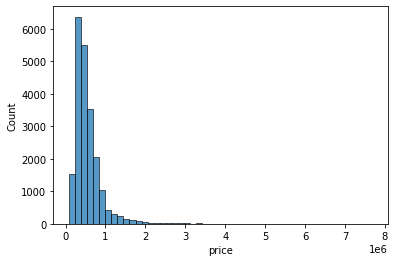

In [4]:
# view price distribution
sns.histplot(dataset['price'], bins = 50)
plt.show()

In [5]:
# take price as label (y)
y = dataset['price']
y = y.values.reshape(-1,1)

# remove price from features (x)
x = dataset.drop(['price'], axis = 1)

# split the data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.70, random_state = 13)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, train_size = 0.80, random_state = 13)

In [6]:
# scale data
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)
xVal = scaler.transform(xVal)

Load and train the neural network with different hyperparameters

In [7]:
# create optimiser class so optimiser can be inputted as argument in baseModel
class Optimiser:
    def __init__(self, lr):
        self.lr = lr

    def getOptim(self, opt):
        name = 'opt_' + str(opt)
        method = getattr(self, name)
        return method()

    def opt_Adam(self):
        return keras.optimizers.Adam(learning_rate=self.lr, clipnorm=1)

    def opt_SGD(self):
        return keras.optimizers.SGD(learning_rate=self.lr, clipnorm=1)

    def opt_Adagrad(self):
        return keras.optimizers.Adagrad(learning_rate=self.lr, clipnorm=1)

    def opt_RMSprop(self):
        return keras.optimizers.RMSprop(learning_rate=self.lr, clipnorm=1)

    def opt_Ftrl(self):
        return keras.optimizers.Ftrl(learning_rate=self.lr, clipnorm=1)

In [8]:
def baseModel(learnRate=0.01, actFunc='relu', optim='SGD', lossFunc='mean_squared_error', hidden=1, nodes=12):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape = 18))
    for layer in range(hidden):
        model.add(layers.Dense(nodes, activation=actFunc))
    call = Optimiser(learnRate)
    model.add(layers.Dense(1))
    model.compile(loss=lossFunc, optimizer=call.getOptim(opt=optim))
    return model

In [9]:
# use baseModel method to make regression object with defaults
baseRegression = KerasRegressor(baseModel, verbose=0)

# fit model to training data and input default batch size and epochs 
baseRegression.fit(xTrain, yTrain, batch_size=32, epochs=100, verbose=0, validation_data=(xVal, yVal))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


The many strategies used for testing multiple hyperparameters

In [10]:
# dictionaries for gridsearch
learnRateParams = {'learnRate': [0.00001, 0.0001, 0.001, 0.01, 0.1]}
actFuncParams = {'actFunc': ['relu', 'sigmoid', 'tanh', 'selu', 'elu']}
optimParams = {'optim': ['SGD', 'Adam', 'Adagrad', 'RMSprop', 'Ftrl']}
lossFuncParams = {'lossFunc': ['mean_squared_error', 'mean_squared_logarithmic_error', 'mean_absolute_error', 'huber']}
hiddenParams = {'hidden': [1, 2, 3, 4, 5]}
nodesParams = {'nodes': [12, 35, 100]}
batchParams = {'batch_size': [8, 16, 32, 64, 128]}
epochParams = {'epochs': [10, 50, 100, 500]}

In [11]:
# run gridsearch for each hyperparameter with cross validation splits of 5
def gridSearch(parameterDict):
    grid = GridSearchCV(estimator=baseRegression, param_grid=parameterDict, cv=5, scoring='neg_mean_squared_error', verbose=0)
    # fit each model to data
    grid.fit(xTrain, yTrain)
    # print best parameter
    return print(grid.best_params_)

In [12]:
def plotLoss(history, paramName):
    plt.plot (history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss for ' + str(paramName), y=1.1)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [13]:
def getHistory(model, paramName):
    # fit model to data and save history for plotting loss
    history = model.fit(xTrain, yTrain, 
                batch_size=32, epochs=100, validation_data=(xVal, yVal),
                verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=10)])

    # print mean squared error for train and test data
    yPredTrain = model.predict(xTrain)
    print('Train data MSE for', paramName, mean_squared_error(yTrain, yPredTrain))
    yPredTest = model.predict(xTest)
    print('Test data MSE for', paramName, mean_squared_error(yTest, yPredTest))

    # plot loss function
    plotLoss(history, paramName)

In [20]:
parameterNames = [learnRateParams, actFuncParams, optimParams, lossFuncParams, hiddenParams, nodesParams, batchParams, epochParams]
for param in parameterNames:
    gridSearch(param)

{'learnRate': 0.1}
{'actFunc': 'relu'}
{'optim': 'Adam'}
{'lossFunc': 'mean_squared_error'}
{'hidden': 5}
{'nodes': 100}
{'batch_size': 8}
{'epochs': 500}


Train data MSE for Base Model 189910196101.04053
Test data MSE for Base Model 203427022077.60623


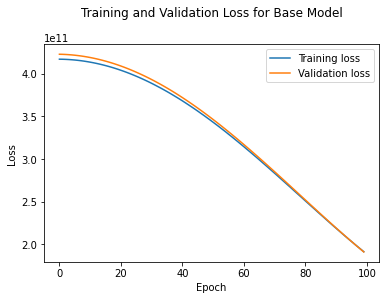

In [31]:
# run base model to use as comparison
modelBase = baseModel()
getHistory(modelBase, 'Base Model')

Train data MSE for Learning Rate 34581195123.20581
Test data MSE for Learning Rate 40340564348.7113


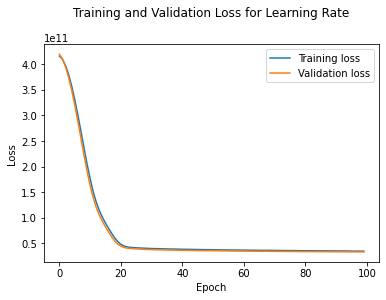

In [21]:
# run each model with optimum hyperparameter changed
modelLR = baseModel(learnRate=0.1)
getHistory(modelLR, 'Learning Rate')

Train data MSE for Activation Function 189936448365.9369
Test data MSE for Activation Function 203438201425.97195


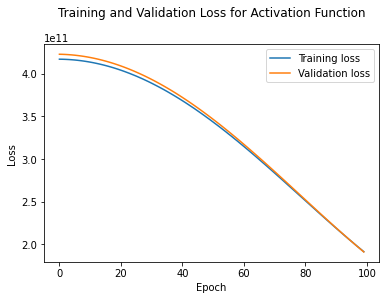

In [22]:
modelAF = baseModel(actFunc='relu')
getHistory(modelAF, 'Activation Function')

Train data MSE for Optimiser 36400650399.679886
Test data MSE for Optimiser 41140729045.95523


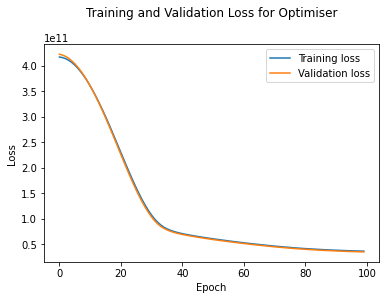

In [23]:
modelOp = baseModel(optim='Adam')
getHistory(modelOp, 'Optimiser')

Train data MSE for Loss Function 190293982574.85095
Test data MSE for Loss Function 203895358820.59076


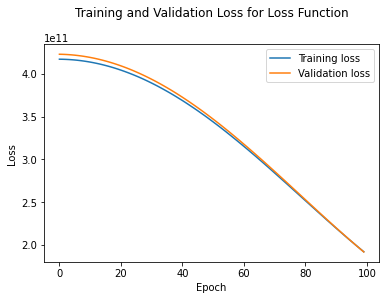

In [24]:
modelLF = baseModel(lossFunc='mean_squared_error')
getHistory(modelLF, 'Loss Function')

Train data MSE for Number of Hidden Layers 22624444392.23838
Test data MSE for Number of Hidden Layers 25758815023.03094


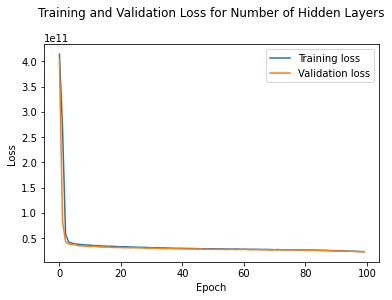

In [25]:
modelHid = baseModel(hidden=5)
getHistory(modelHid, 'Number of Hidden Layers')

Train data MSE for Number of Nodes on Hidden Layers 190344405964.8596
Test data MSE for Number of Nodes on Hidden Layers 203943848167.57364


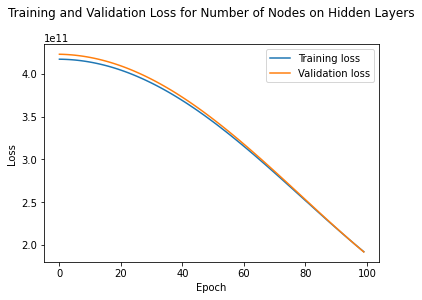

In [26]:
modelNode = baseModel(nodes=100)
getHistory(modelNode, 'Number of Nodes on Hidden Layers')

Test data MSE for Batch Size 52005618064.923676
Test data MSE for Batch Size 52005618064.923676


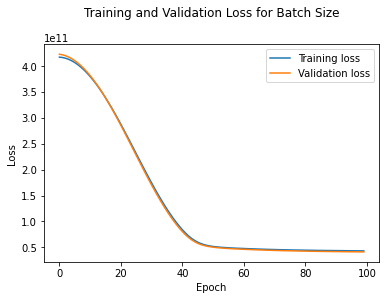

In [27]:
# for optimum batch size
modelBS = baseModel()
history = modelBS.fit(xTrain, yTrain, 
            batch_size=8, epochs=100, validation_data=(xVal, yVal), 
            verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=10)])
yPredTrainBS = modelBS.predict(xTest)
print('Test data MSE for Batch Size', mean_squared_error(yTest, yPredTrainBS))
yPredTestBS = modelBS.predict(xTest)
print('Test data MSE for Batch Size', mean_squared_error(yTest, yPredTestBS))
plotLoss(history, 'Batch Size')

Test data MSE for Epochs 44078884149.88514
Test data MSE for Epochs 44078884149.88514


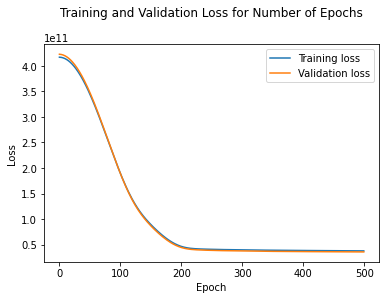

In [28]:
# for optimum epochs
modelEp = baseModel()
history = modelEp.fit(xTrain, yTrain, 
            batch_size=32, epochs=500, validation_data=(xVal, yVal),
            verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=10)])
yPredTrainEP = modelEp.predict(xTest)
print('Test data MSE for Epochs', mean_squared_error(yTest, yPredTrainEP))
yPredTestEP = modelEp.predict(xTest)
print('Test data MSE for Epochs', mean_squared_error(yTest, yPredTestEP))
plotLoss(history, 'Number of Epochs')

Plot the results for the best network obtained

Train data MSE for Best Hyperparameters 73409319464.93542
Test data MSE for Best Hyperparameters 85614799281.05376


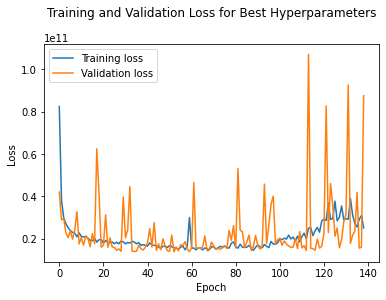

In [29]:
# run model with all best parameters
modelBest = baseModel(learnRate=0.1, actFunc='relu', optim='Adam', lossFunc='mean_squared_error', hidden=5, nodes=100)
history = modelBest.fit(xTrain, yTrain, 
            batch_size=8, epochs=500, validation_data=(xVal, yVal),
            verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=50)])
yPredTrainBest = modelBest.predict(xTrain)
print('Train data MSE for Best Hyperparameters', mean_squared_error(yTrain, yPredTrainBest))
yPredTestBest = modelBest.predict(xTest)
print('Test data MSE for Best Hyperparameters', mean_squared_error(yTest, yPredTestBest))
plotLoss(history, 'Best Hyperparameters')

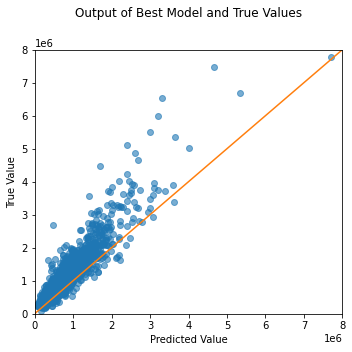

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(yTest, yPredTestBest, alpha=0.6)

plt.xlim(0, 8e6)
plt.ylim(0, 8e6)
ax.plot([0, 8e6], [0, 8e6], color='tab:orange')
plt.title('Output of Best Model and True Values', y=1.1)
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.tight_layout()
plt.show()